In [1]:
import numpy as np   # import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

In [2]:
# Function to read in a dataframe column of spider data (a series) and the interval between measurements
# in minutes and, to return the period (in minutes) and the power from the Lomb-Scargle periodogram method
# Note that the variables start_index and end_index were set by trial and error, and could need adjustment
# if the results for period and power seem questionable. 

# Now expanded to also read in a file_base string and a spider_string (with a spider number in the form 's#' typically),
# and save a png file of the calculated LS Periodogram. Also now returns a 'false alarm probability', which estimates
# the chance that the peak maximum observed in the periodogram could arise by random chance if the data were Gaussian
# noise with no periodic component

def Function_LS_Deluxe(file_base,spider_string,series,min_interval):  # set min_interval to the time between measurements in minutes

    steps = len(series)    # find number of items in the input spider data
    time_input = np.linspace(1,steps,num=steps)  # create a time grid for the LombScargle routine
#    ls = LombScargle(time_input, series, normalization='standard') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='model') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='log') # calculate LombScargle p-gram and put in object 'ls'
    ls = LombScargle(time_input, series, normalization='psd') # calculate LombScargle p-gram and put in object 'ls'
    min_freq = 1./(34.*60.) * min_interval
    max_freq = 1./(14.*60.) * min_interval
#    print(min_freq, max_freq)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq,samples_per_peak=50)  
                                # extract the frequency and power arrays with specified frequency limits and grid spacing
    period = 1./frequency * min_interval / 60.  # create an array of periods from the array of frequencies
    max_power = np.amax(power, axis = 0)  # find the value of the maximum power within restricted range
    period_max_hr = np.abs(1/(frequency[np.where(power == max_power)]))*min_interval / 60.  # locate 
                                                                        # period where max power occurs and express in hours
    false_alarm_prob = ls.false_alarm_probability(max_power) # extract the false alarm probability for peak with height max_power
    plt.figure()    # create periodogram figure
    title_string = spider_string 
    filename = spider_string+'.png'   # construct output filename for the periodogram 
    plt.title(title_string)   # set title
    plt.xlabel("Period (hr)")  # set x-axis label
    plt.ylabel("Lomb-Scargle Amplitude") # set y-axis label
    plt.plot(period,power,linewidth=2)  # plot the periodogram
    plt.plot(period_max_hr,max_power,color='red',marker='o')  # put a circular point at the max peak
    #plt.savefig(filename,dpi=300)  # save the periodogram file
    plt.close()  # close the periodogram figure
    return (period_max_hr.item(), max_power, false_alarm_prob)  # returns period, max_power, false_alarm as floating points

In [3]:
# Function to take in base filenames (i.e., with '.csv' stripped off) of spider data and spider metafile  
# (with Alive/Circadian specified) and to return a dataframe of only the Alive/Circadian spiders with their 
# Periods/Amplitudes/False Alarm Probabilities using the Lomb-Scargle Periodogram method from astropy. 
# Each spider also has a periodogram output as a 300-dpi .png file.
# Note this function calls the function Function_LS_Deluxe in the above cell

def LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base):
    spider_data_filename = spider_datafile_base + '.csv'  # reconstruct spider data full filename
    df_spider = pd.read_csv(spider_data_filename, index_col=0) # read in all the spider data from the given filename
    df_spider.index = pd.to_datetime(df_spider.index)            # reset indexes to datetime format for convenience
    spiderac_list_all = df_spider.columns.values.tolist()       # extract list of all column names from dataframe
    spiderac_list =  spiderac_list_all[1:]                      #  restrict list to column names that are spider names
    output_columns = ['Spider','Period','Amplitude','p value']    # prepare column names for the output dataframe
    df_output = pd.DataFrame(columns = output_columns)  # create an empty dataframe with the output column names
    for spider_name in spiderac_list:             # loop over the names of the alive/circadian spiders
        column_name = spider_name                 # set the current column name within the spider dataframe 
#        df_spider[column_name] = df_spider[column_name].fillna(0)  # replace any stray values with zeroes to prevent errors
        column = df_spider[column_name]           # get the column (series) data for the current spider
#        print(type(column))
#        print(spider_name, ' ',column.max())
#        if (column.max()>0):  # prevent error that occurs when series of data is all zero
        dt = df_spider.index.minute[1]-df_spider.index.minute[0]  # use the datetime format to find measurement interval
        pmax, amp, false_alarm = Function_LS_Deluxe(spider_datafile_base,spider_name,column,dt) 
                                                    # call above function to find period, max power, and false alarm probability
#        else:
#            pmax, amp, false_alarm = [0.0,0.0,1.0]
        df_add = pd.DataFrame([[spider_name,pmax,amp,false_alarm]],columns=output_columns)  # prepare a row to be added to the output dataframe
        df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
    return(df_output)                             # return the full output dataframe

In [4]:
spider_datafile_base = "Metazygia monitor 1_DD"       # specify the base filename for the set of spiders                       
df_out = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_out = df_out.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_out.head())                       # show the dataframe below

,Period,Amplitude,p value
Spider,,,
Monitor 1 Spider 1,22.011150,1322.464061,0.0
Monitor 1 Spider 2,21.316001,5333.174854,0.0
Monitor 1 Spider 3,24.453386,1734.088370,0.0
Monitor 1 Spider 4,24.676897,2695.489814,0.0
Monitor 1 Spider 5,21.316001,790.538587,0.0


In [5]:
day=60*24
minusone=pd.read_csv('Metazygia monitor 1_DD.csv',index_col=0)
minusone=minusone.iloc[day:]
minusone.to_csv('Metazygia monitor 1_DD-MINUS DAY 1.csv') 

minustwo=pd.read_csv('Metazygia monitor 1_DD.csv', index_col=0)
minustwo=minustwo.iloc[(2*day):]
minustwo.to_csv('Metazygia monitor 1_DD-MINUS DAY 1 AND 2.csv') 


In [6]:
spider_datafile_base = "Metazygia monitor 1_DD-MINUS DAY 1"       # specify the base filename for the set of spiders                       
df_outone = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outone = df_outone.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_outone.to_csv(outfile)                # output the dataframe to file
display(df_outone.head())                       # show the dataframe below

,Period,Amplitude,p value
Spider,,,
Monitor 1 Spider 1,22.101170,1010.056873,0.0
Monitor 1 Spider 2,21.411015,4755.658497,0.0
Monitor 1 Spider 3,24.159275,900.356893,0.0
Monitor 1 Spider 4,24.592538,2388.728546,0.0
Monitor 1 Spider 5,21.949560,944.353335,0.0


In [7]:
spider_datafile_base = "Metazygia monitor 1_DD-MINUS DAY 1 AND 2"       # specify the base filename for the set of spiders                       
df_outtwo = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outtwo = df_outtwo.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_outtwo.head())                       # show the dataframe below

,Period,Amplitude,p value
Spider,,,
Monitor 1 Spider 1,22.101074,823.454875,0.0
Monitor 1 Spider 2,21.315825,4434.849359,0.0
Monitor 1 Spider 3,23.072459,973.136330,0.0
Monitor 1 Spider 4,25.144622,1958.630422,0.0
Monitor 1 Spider 5,22.637170,1084.180758,0.0


In [24]:
#Create uniform y-axis limit
def create_ylimit(df):
    #find the standard deviation and mean of each column from the dataset without zeros
    df_limit=df.replace(0, np.nan)
    std=df_limit.std()
    mean=df_limit.mean()
    #Find mean and standard deviation of all of the data
    df_mean=np.mean(mean)
    df_std =np.mean(std)
    #y limit = mean of the dataframe plus 3 standard deviations
    y_limit = df_mean +3*df_std
    return y_limit

def plot_night_test(df):
    #Make a copy of the dataframe and create two columns for the difference between the light values and for the date and time
    dfc = df.copy()
    dfc['diff'] = dfc.lights.diff()
    dfc=dfc.reset_index()
    dfc[["day", "time"]] = dfc["Date_Time"].str.split(" ", expand = True)
    #Separate by the difference to determine when the light is coming on or going off
    df_off = dfc.loc[dfc['diff'] == 1]
    df_on = dfc.loc[dfc['diff'] == -1]
    #Assign variable from the lists
    start1 = dfc.time.values[0]
    end1 = df_off.time.values[0]
    start2 = df_on.time.values[0]
    end2 = dfc.time.values[-1]

    return start1, start2, end1, end2

#Plot activity in subplots
#Imput:Dataframe, List of spiders in df, Specific Spider from list, 
#Label for subplots, variable from "create_ylimit" funnction 
#All variables will be named in final raster plot function
def plot_raster( df, column, spider, ax, y, num_days, min_day): 
    
    for i in range(0,num_days):
        #Separate dataframe into sections of 1440 minutes(minutes in a day) and plot the 
        #activity for each day
        ax[i].plot(df['time'][min_day*i:min_day*(i+1)], df[column[spider]][min_day*i:min_day*(i+1)], color='blue')
        #Label each day
        ax[i].set_ylabel('Subj. Day '+str(i+1))
        #ax[i].set_ylabel(df.day[min_day*i])
        ax[i].set_xticks([])
        # the y limit is the mean plus 3 standard deviations
        ax[i].set_ylim(0,y)
        #setting instructions for shading the graph when the lights are off
        df1=df[min_day*(i):min_day*(i+1)]
        #df1=df1.reset_index()
    
        #Make DD plots all grey
        if np.mean(df1.lights)==0:
            ax[i].axvspan(0,min_day, alpha=.5,color='grey')
        #Run function to determine when lights are off during LD cycle
        else:
            start1, start2, end1, end2 = plot_night_test(df1)
            ax[i].axvspan(start1, end1, alpha=0.5, color='grey')
            ax[i].axvspan(start2, end2,alpha=0.5, color='grey')
            
#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster(df, per):
    #create a copy and separate the date and time for reference
    global df_time
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date_Time"].str.split(" ", expand = True)
    #min_day= 1440
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        global perT
        perT = per.T
        #display(perT)
        min_day = int((perT[column[spider]].values) * 60)
        #sub_mins_day = per.iloc[0]['A']
        #print(min_day)
        total_time = len(dftest.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True, sharex=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        #ax[num_days-1].set_xticks(range(0, min_day, 360))
        plt.xlabel('Time')
        #save figure
        #fig.savefig(column[spider] +'raster.jpg')
        #plt.show()
        print('Next spider')

In [25]:
df=pd.read_csv('Metazygia monitor 1_DD.csv', index_col=0)

column=df.columns[1:]
perone=pd.DataFrame(data= df_outone['Period'],index=column)
pertwo=pd.DataFrame(data= df_outtwo['Period'],index=column)
per=pd.DataFrame(data=df_out['Period'],index=column)

Monitor 1 Spider 1
Next spider
Monitor 1 Spider 2
Next spider
Monitor 1 Spider 3
Next spider
Monitor 1 Spider 4
Next spider
Monitor 1 Spider 5
Next spider
Monitor 1 Spider 6
Next spider
Monitor 1 Spider 7
Next spider
Monitor 1 Spider 8
Next spider
Monitor 1 Spider 9
Next spider
Monitor 1 Spider 10
Next spider
Monitor 1 Spider 11
Next spider
Monitor 1 Spider 12
Next spider
Monitor 1 Spider 13
Next spider
Monitor 1 Spider 14
Next spider
Monitor 1 Spider 15
Next spider
Monitor 1 Spider 16
Next spider
Monitor 1 Spider 18
Next spider
Monitor 1 Spider 19
Next spider
Monitor 1 Spider 20
Next spider
Monitor 1 Spider 21
Next spider
Monitor 1 Spider 25


<ipython-input-24-f38e6eb0e1e5>:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True, sharex=True)


Next spider
Monitor 1 Spider 26
Next spider
Monitor 1 Spider 27
Next spider
Monitor 1 Spider 28
Next spider
Monitor 1 Spider 29
Next spider
Monitor 1 Spider 30
Next spider
Monitor 1 Spider 31
Next spider
Monitor 1 Spider 32
Next spider


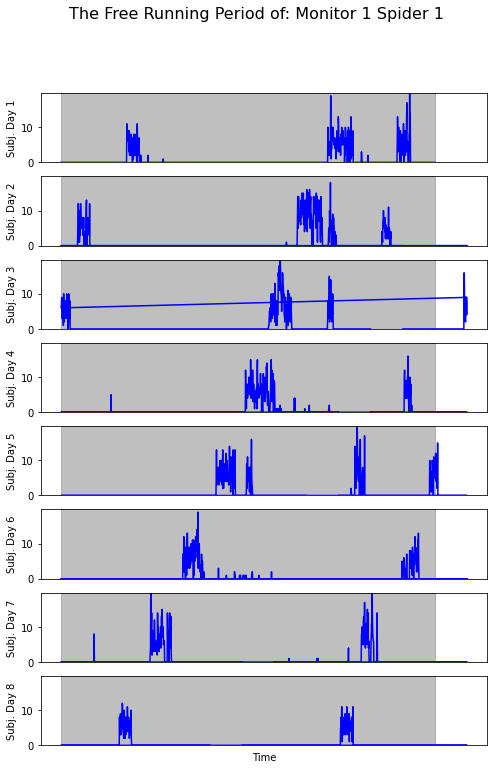

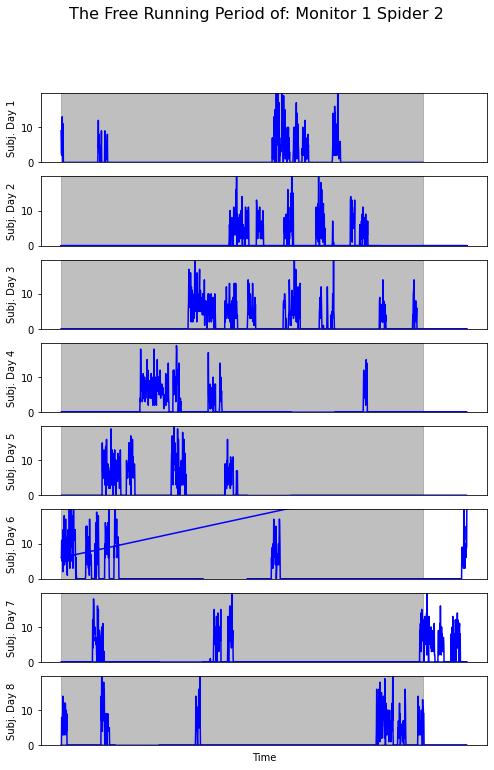

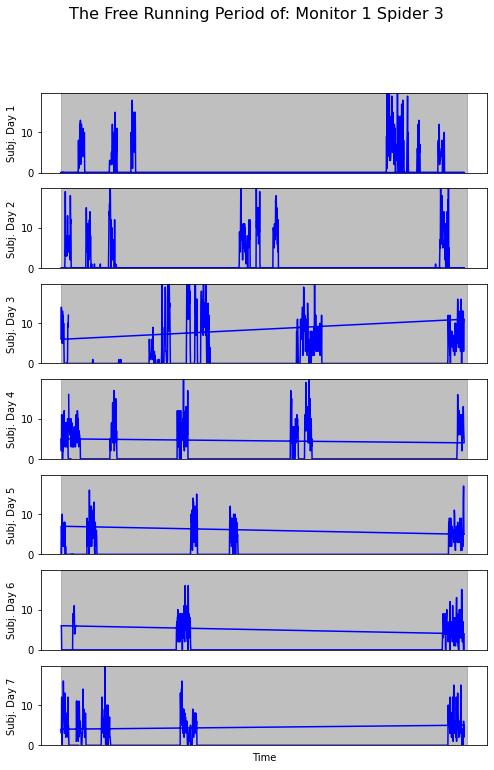

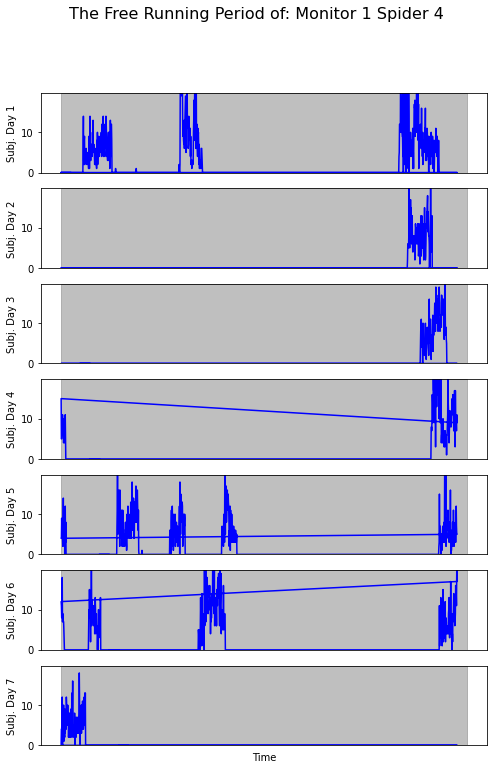

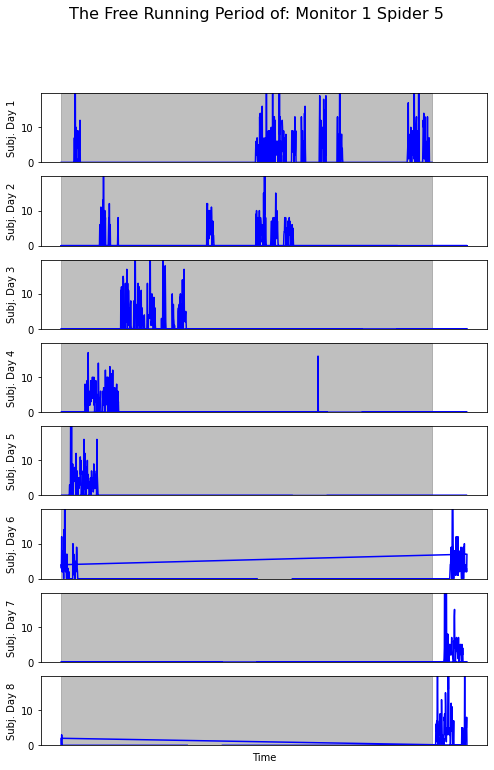

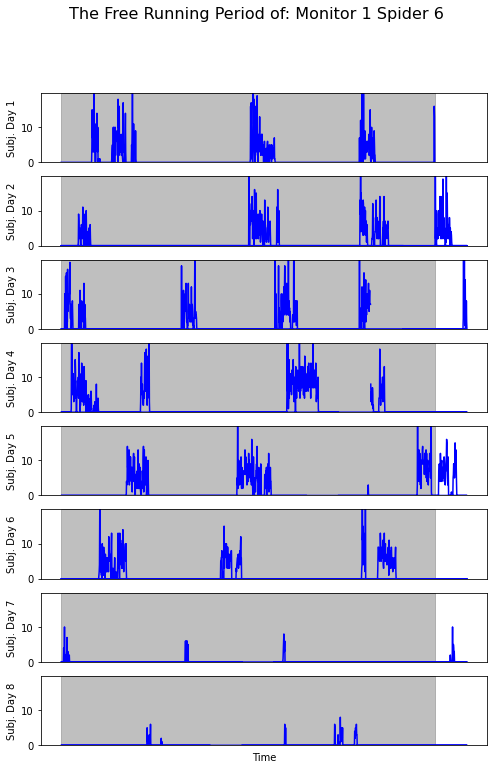

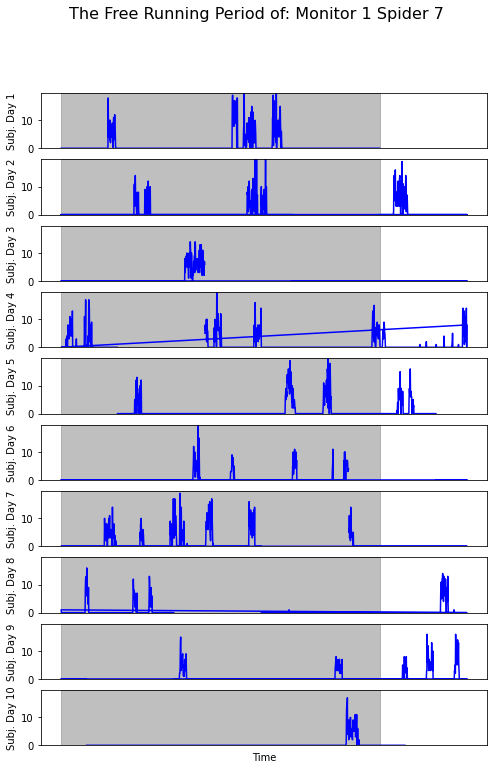

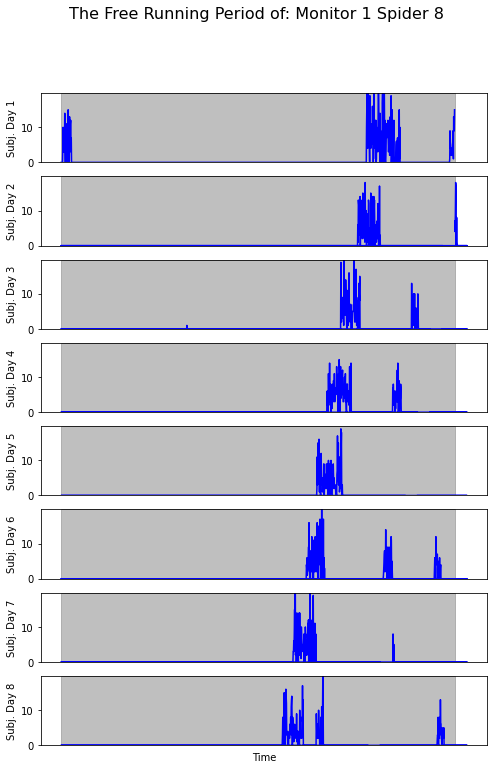

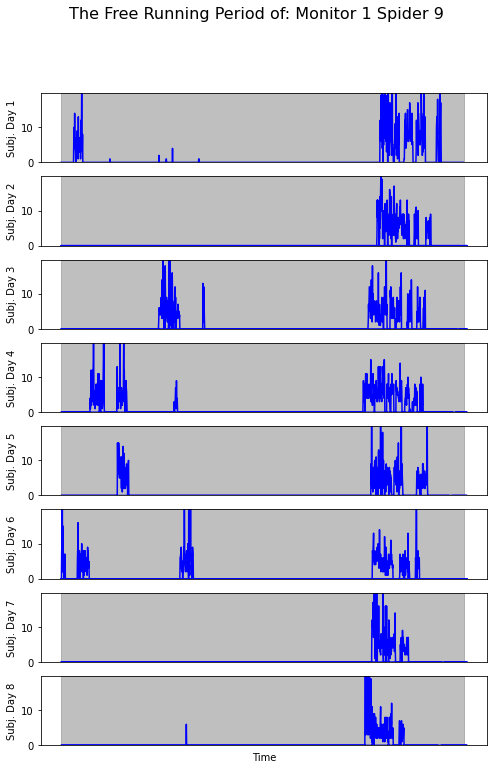

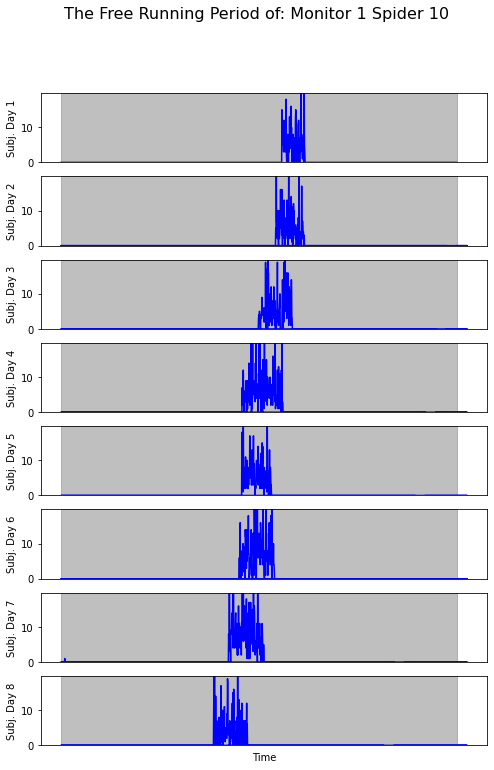

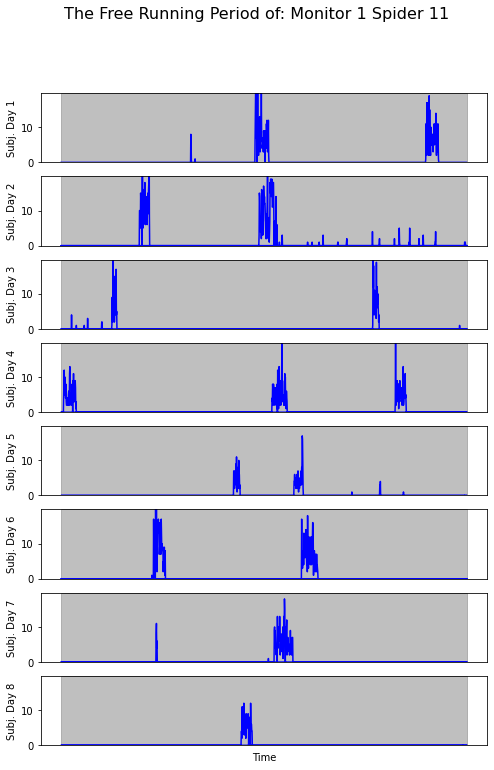

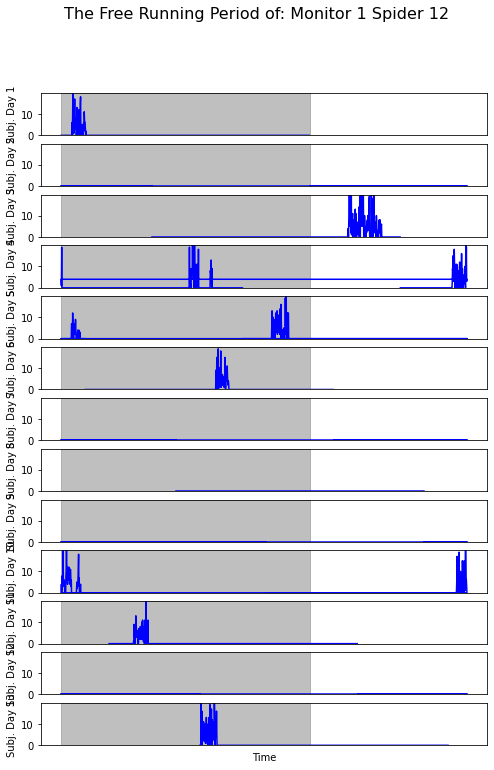

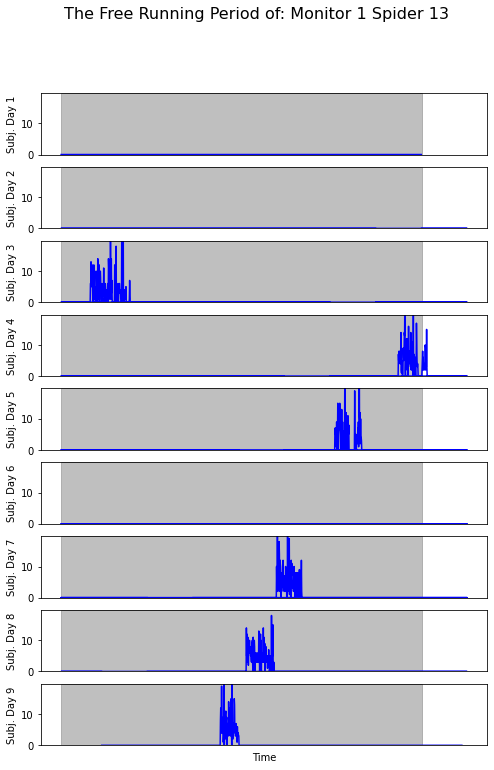

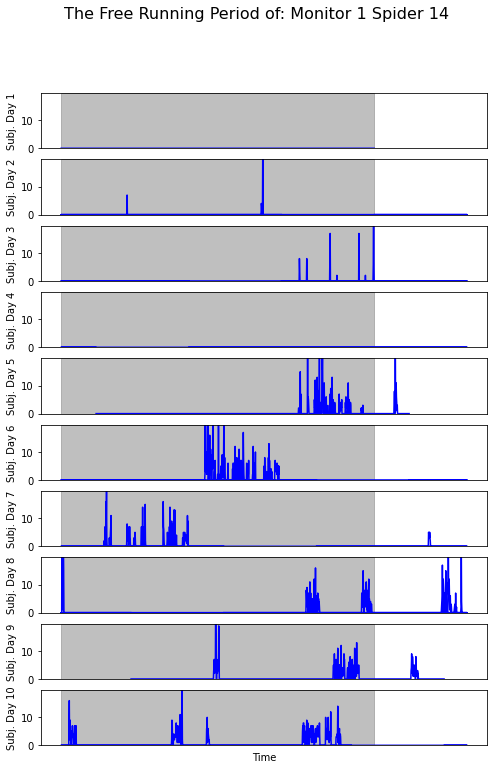

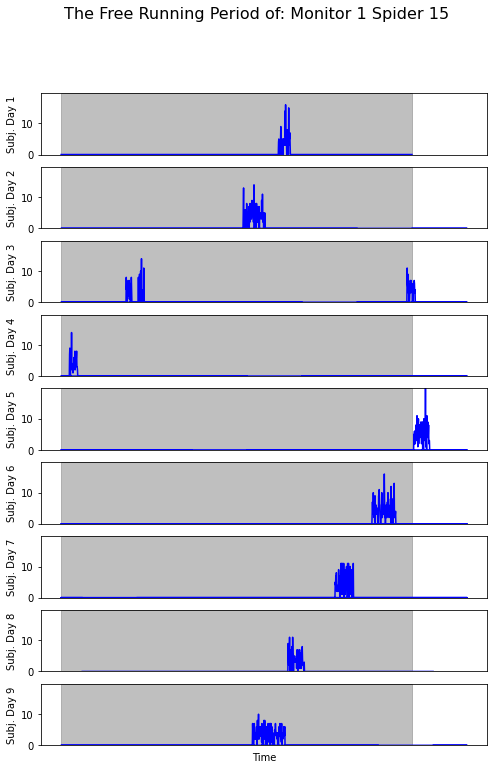

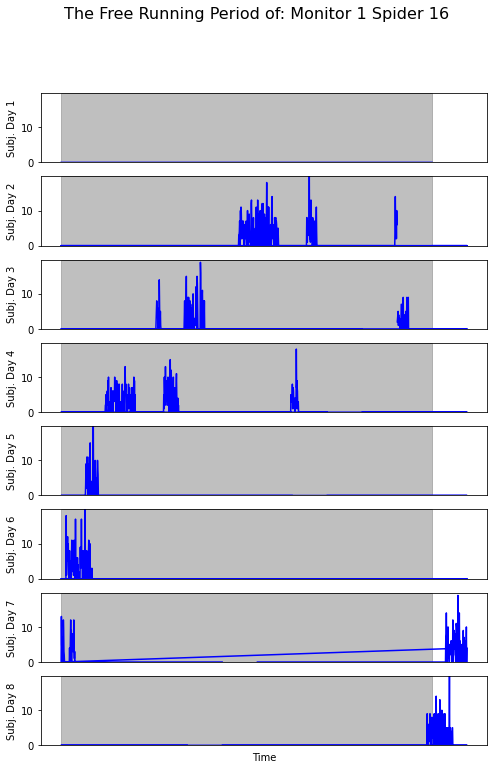

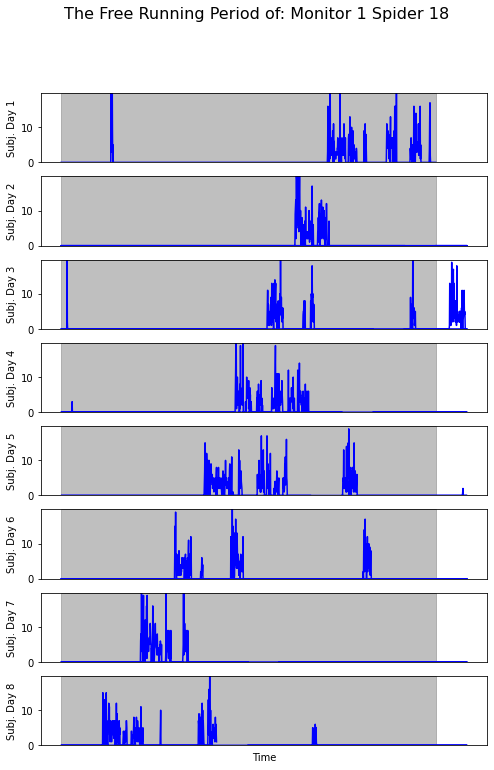

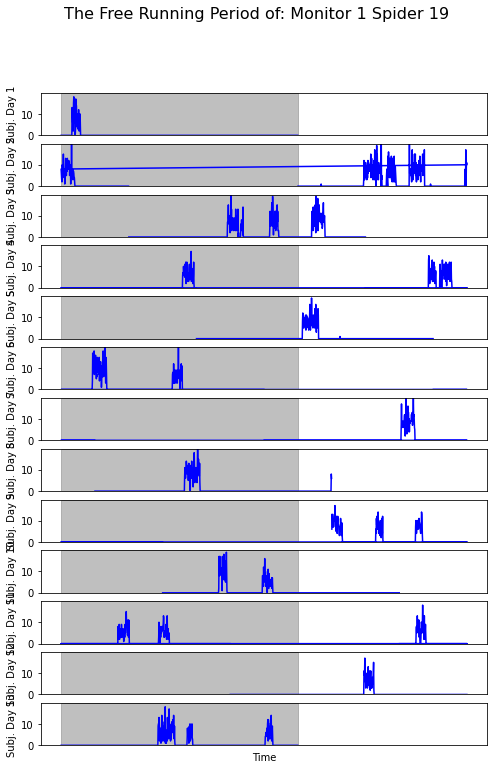

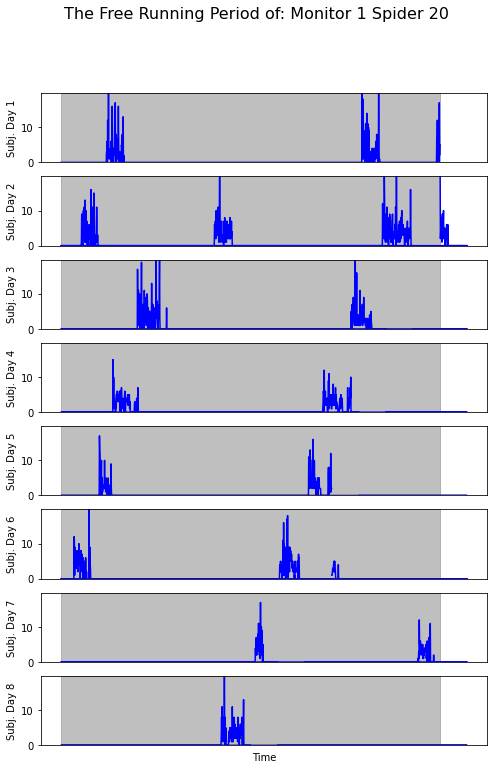

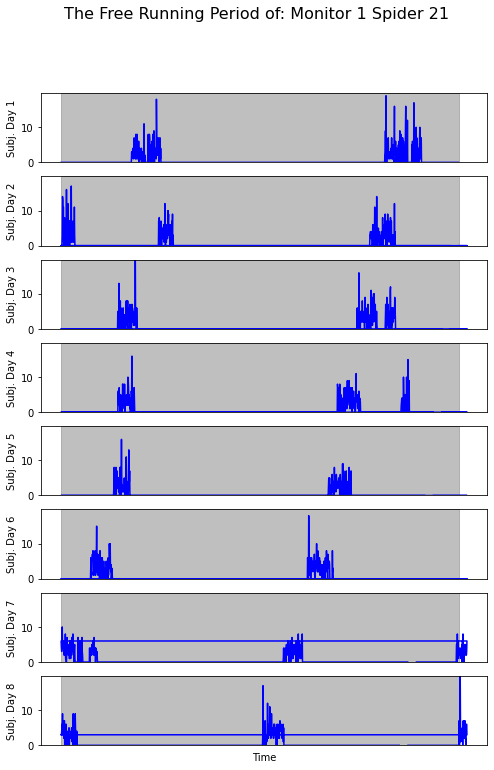

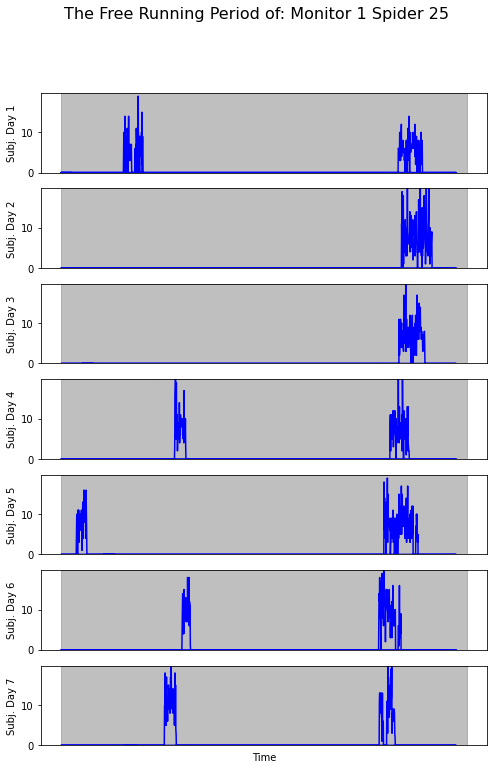

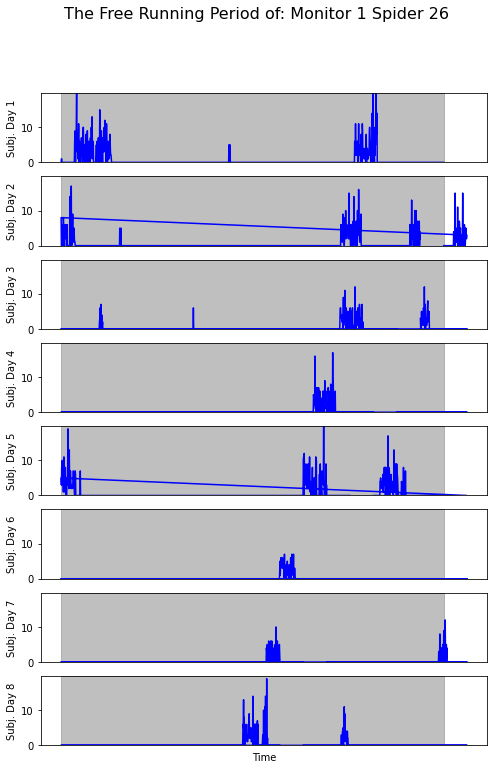

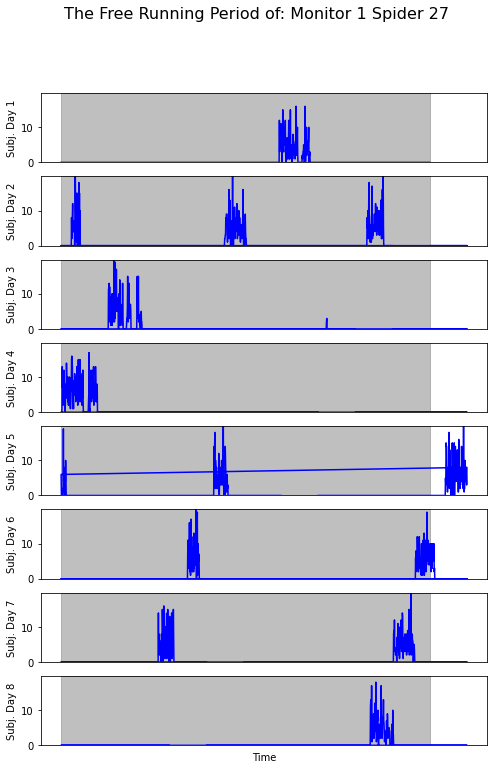

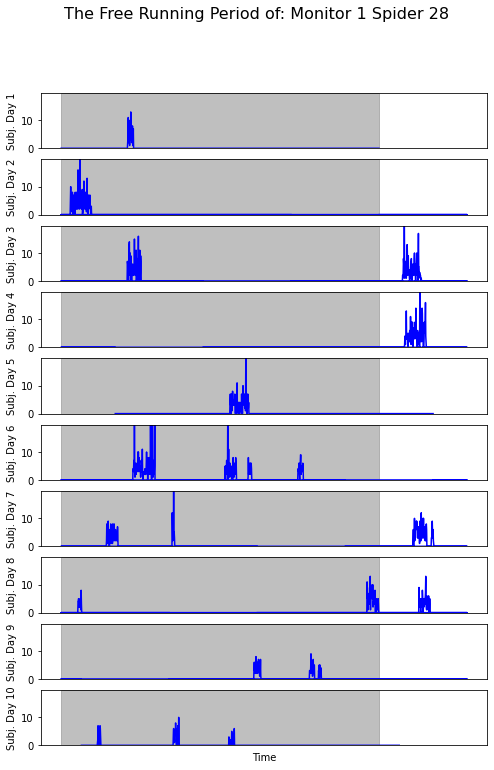

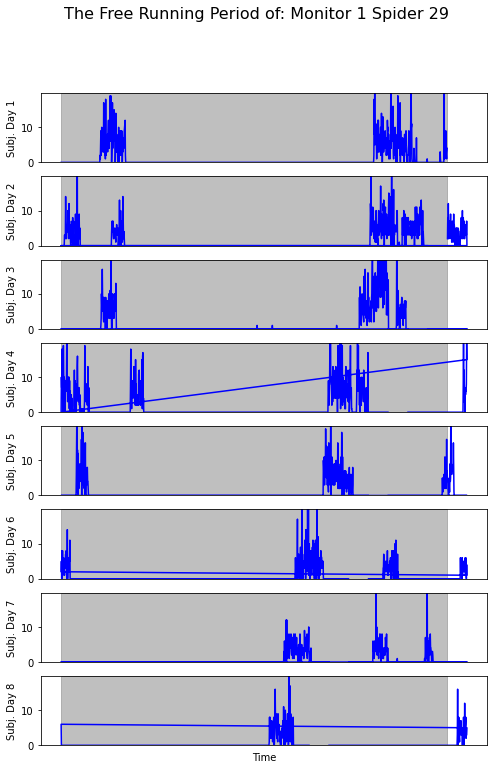

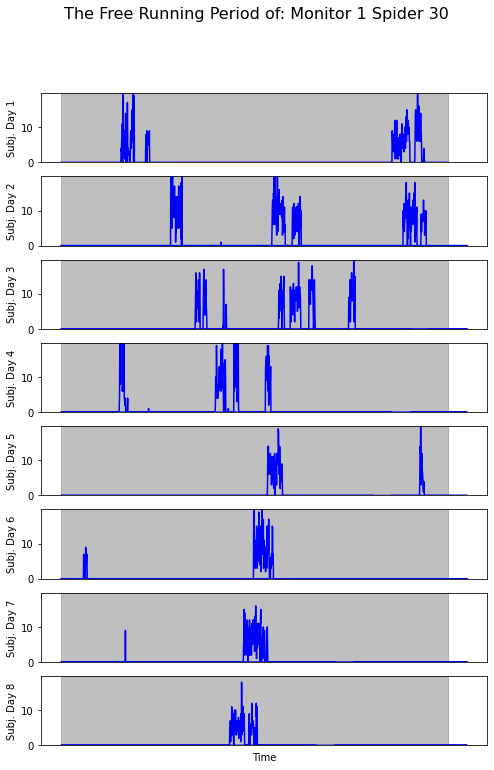

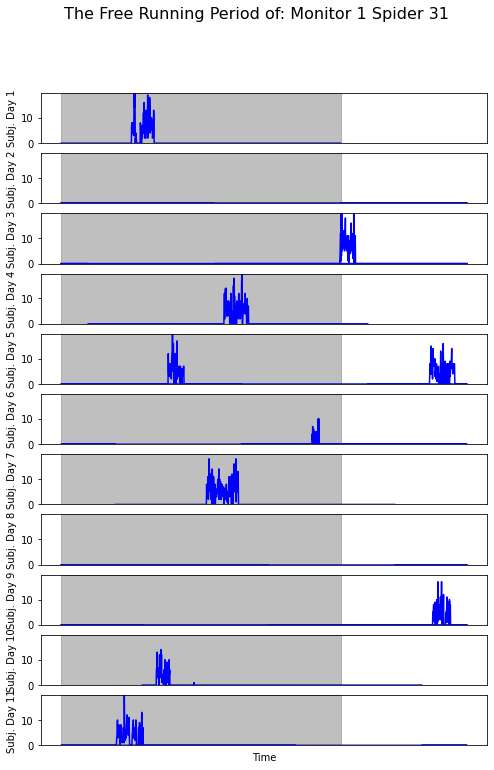

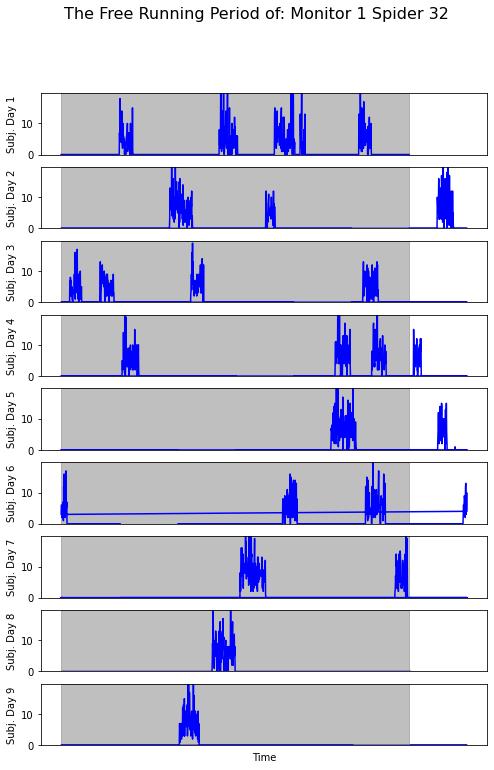

In [26]:
spider_raster(minusone, perone)

In [ ]:
spider_raster(minustwo,pertwo)

Monitor 1 Spider 1
Next spider
Monitor 1 Spider 2
Next spider
Monitor 1 Spider 3
Next spider
Monitor 1 Spider 4
Next spider
Monitor 1 Spider 5
Next spider
Monitor 1 Spider 6
Next spider
Monitor 1 Spider 7
Next spider
Monitor 1 Spider 8
Next spider
Monitor 1 Spider 9
Next spider
Monitor 1 Spider 10
Next spider
Monitor 1 Spider 11
Next spider
Monitor 1 Spider 12
Next spider
Monitor 1 Spider 13
Next spider
Monitor 1 Spider 14
Next spider
Monitor 1 Spider 15
Next spider
Monitor 1 Spider 16
Next spider
Monitor 1 Spider 18
Next spider
Monitor 1 Spider 19
Next spider
Monitor 1 Spider 20
Next spider
Monitor 1 Spider 21
Next spider
Monitor 1 Spider 25


<ipython-input-24-f38e6eb0e1e5>:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True, sharex=True)


Next spider
Monitor 1 Spider 26
Next spider
Monitor 1 Spider 27
Next spider
Monitor 1 Spider 28
Next spider
Monitor 1 Spider 29
Next spider
Monitor 1 Spider 30
Next spider
Monitor 1 Spider 31
Next spider
Monitor 1 Spider 32
Next spider


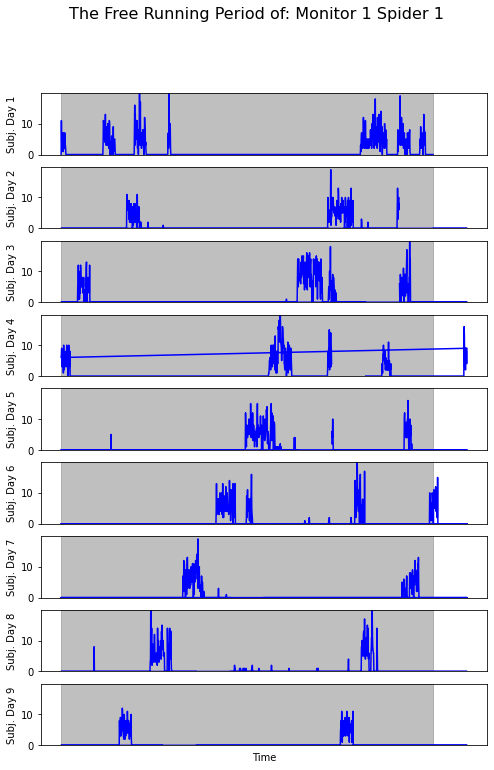

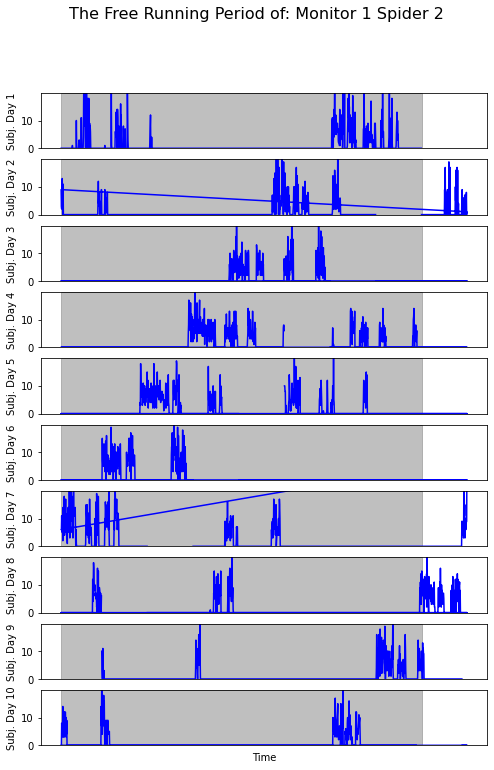

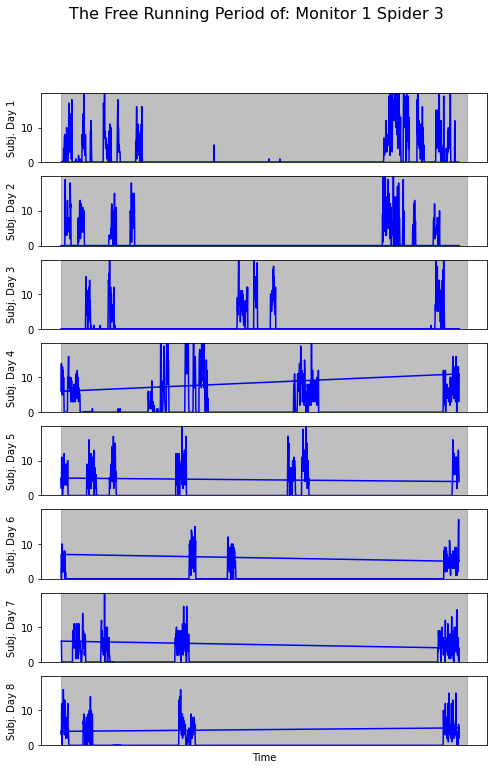

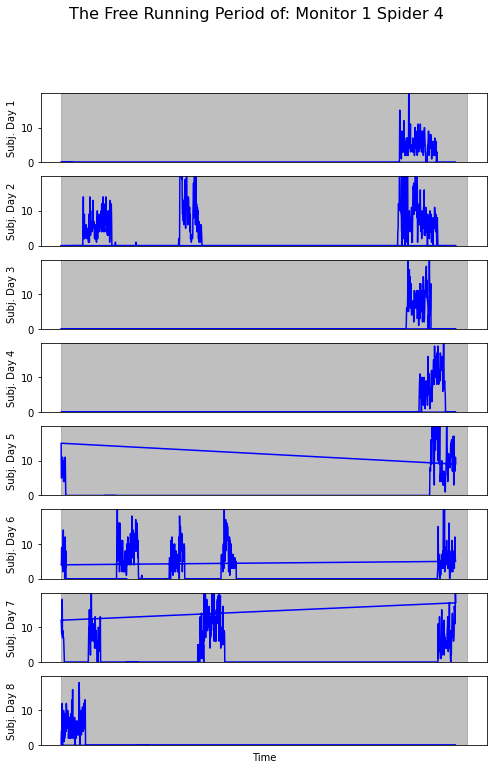

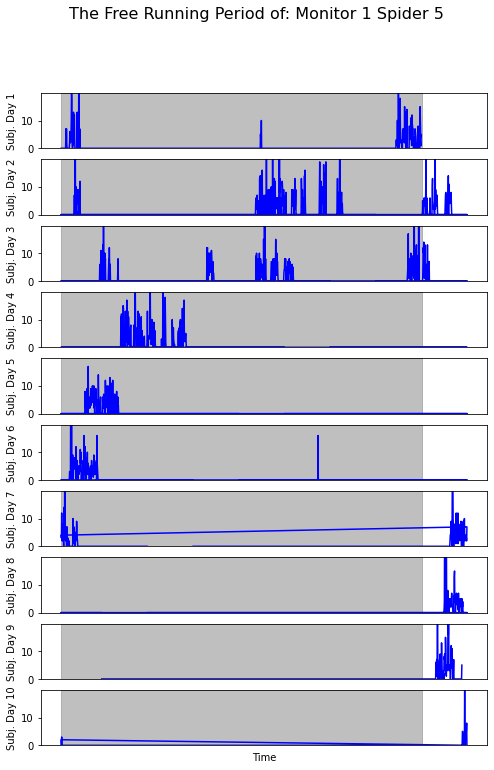

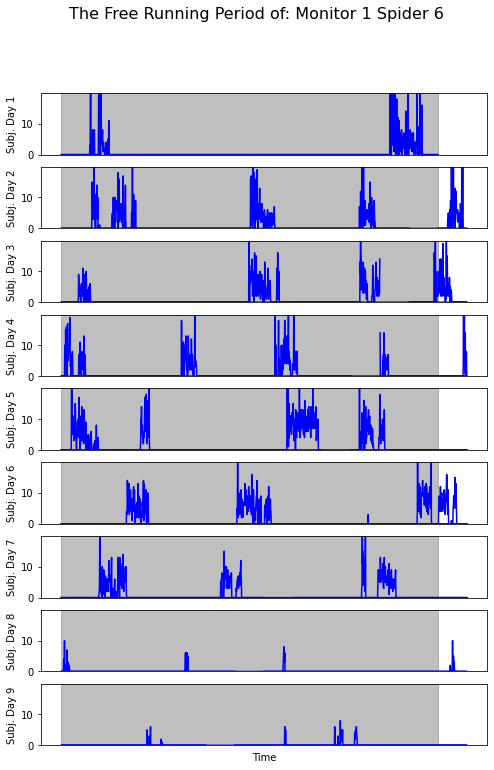

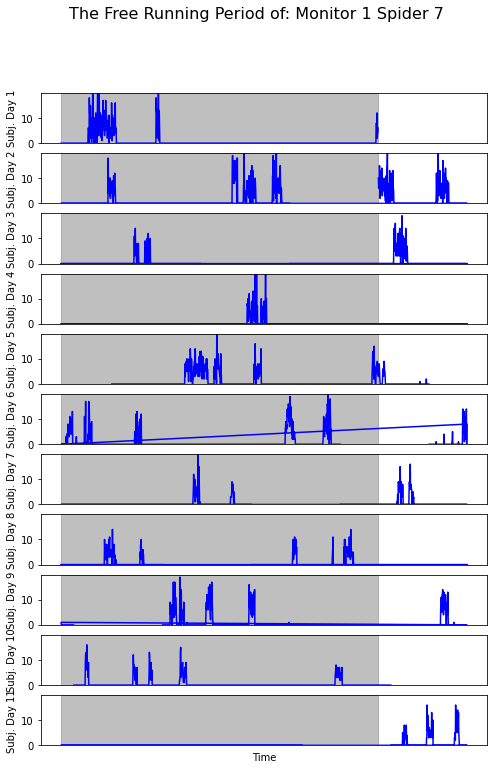

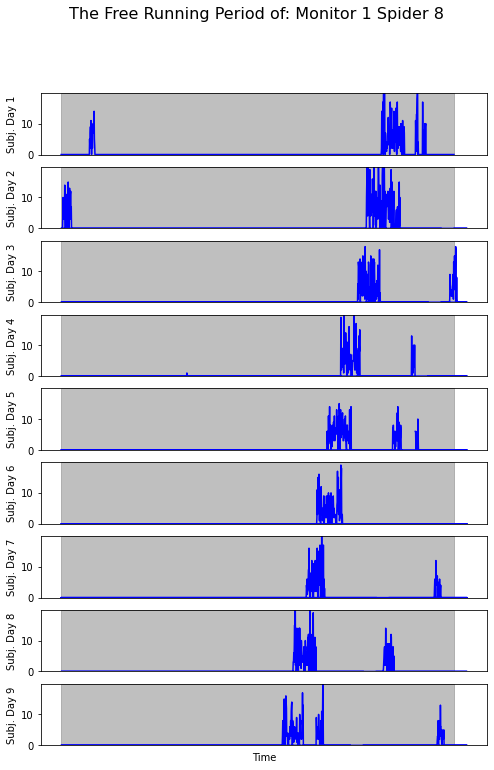

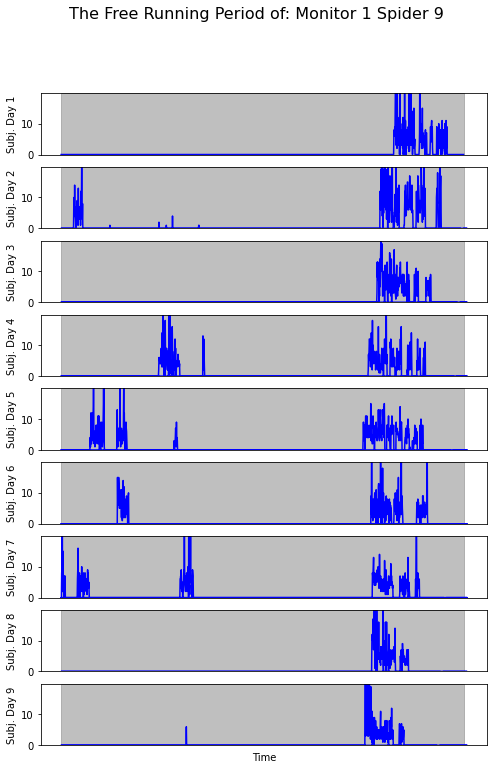

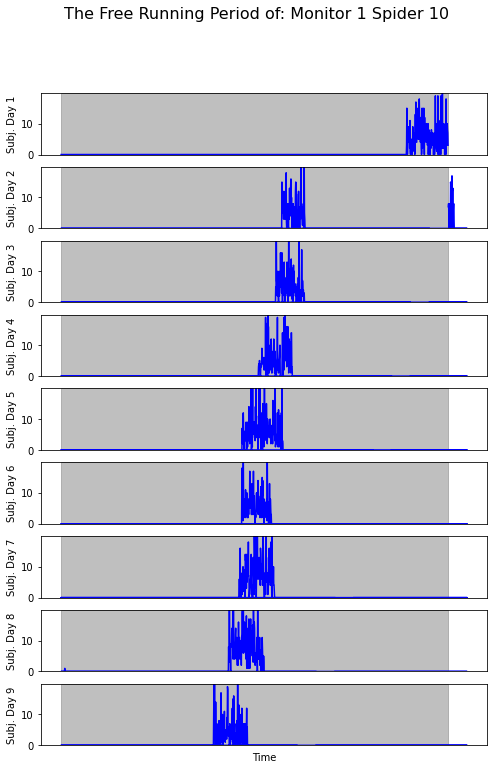

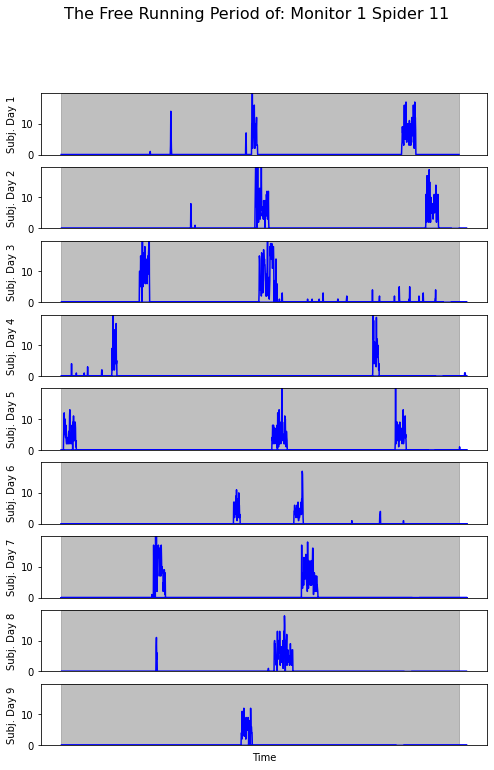

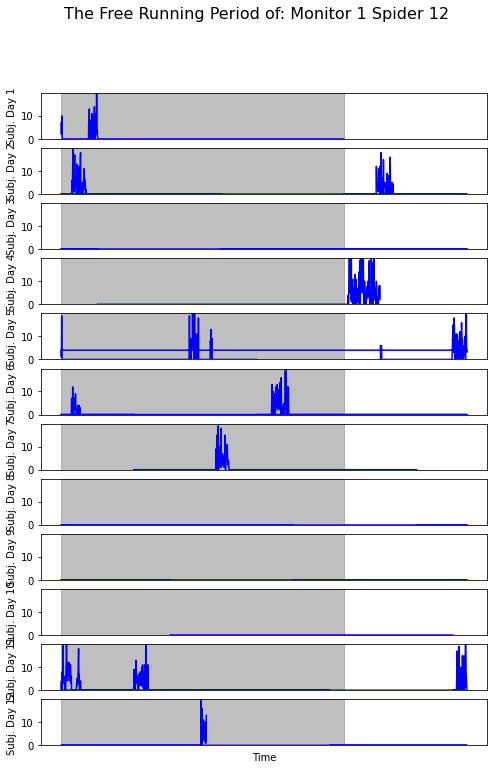

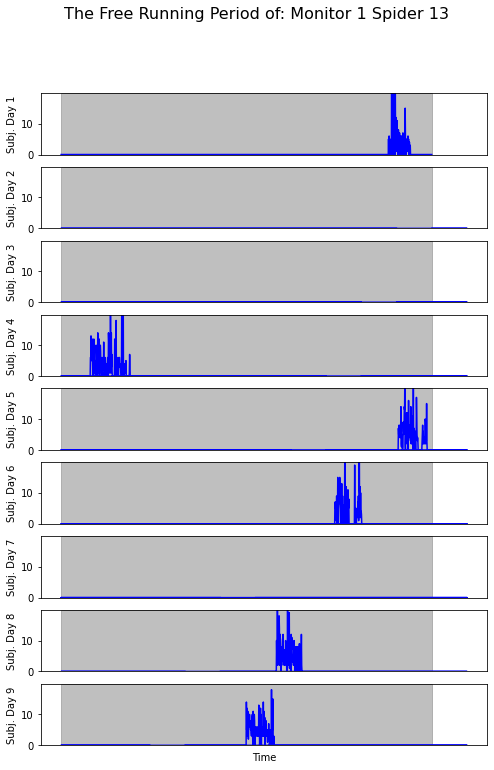

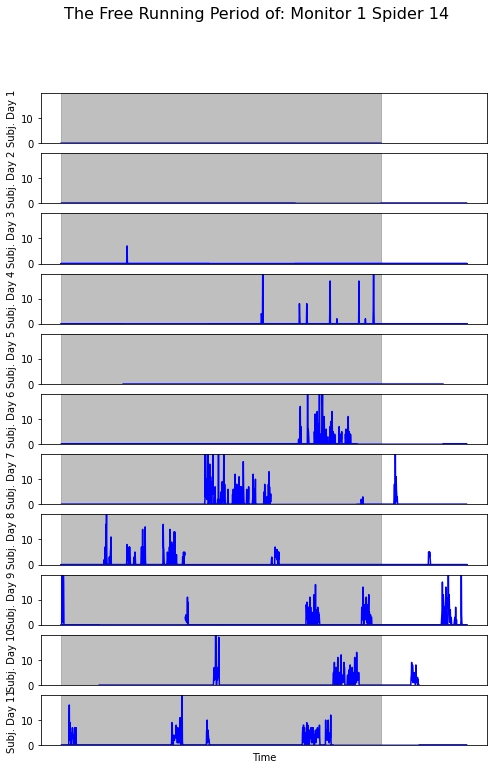

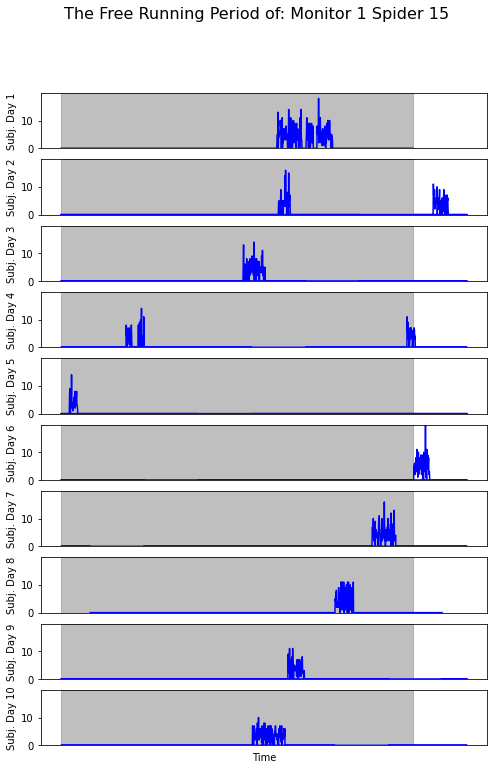

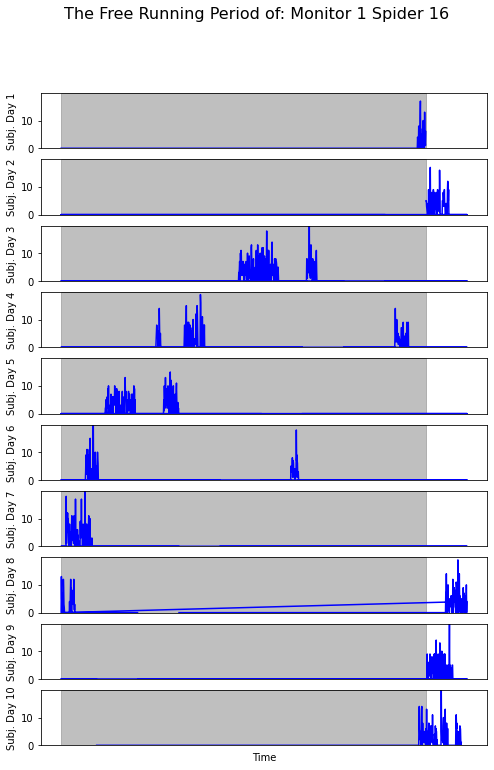

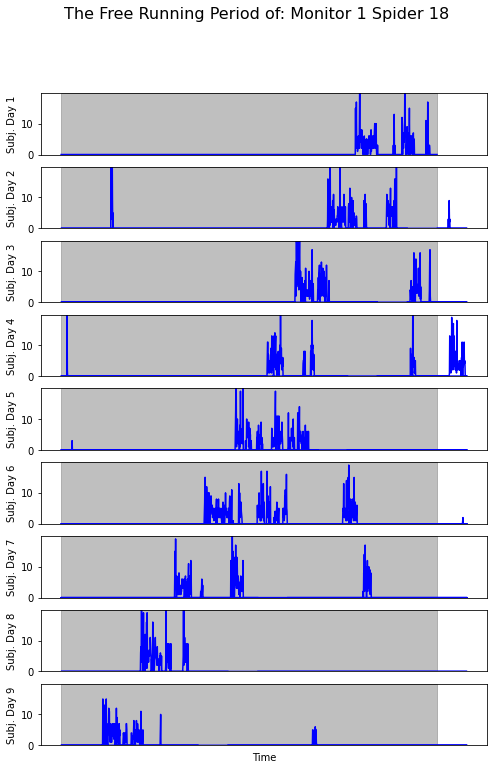

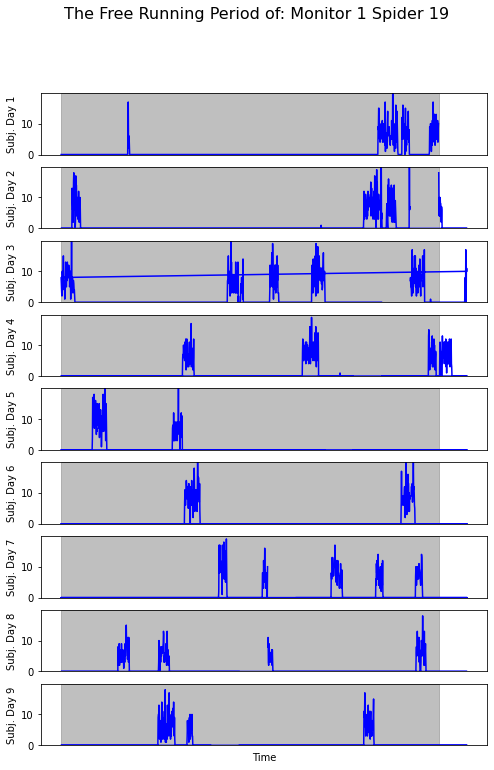

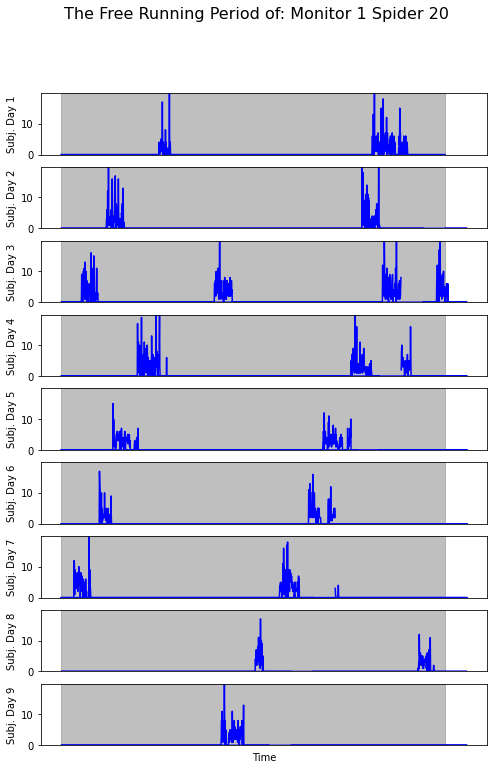

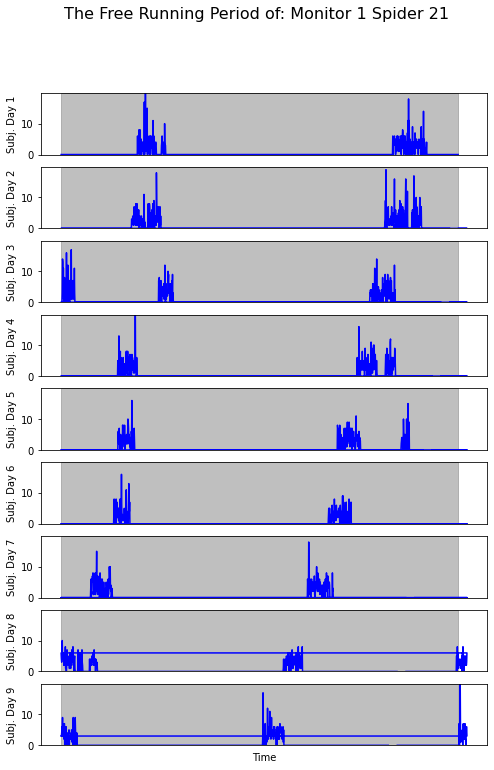

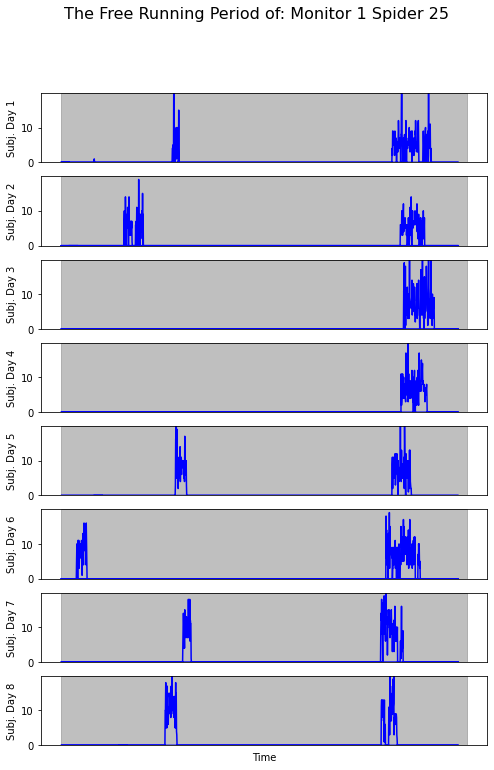

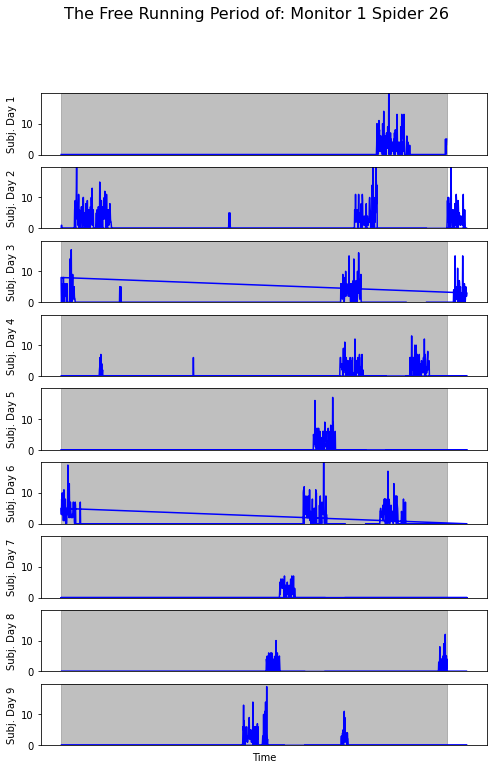

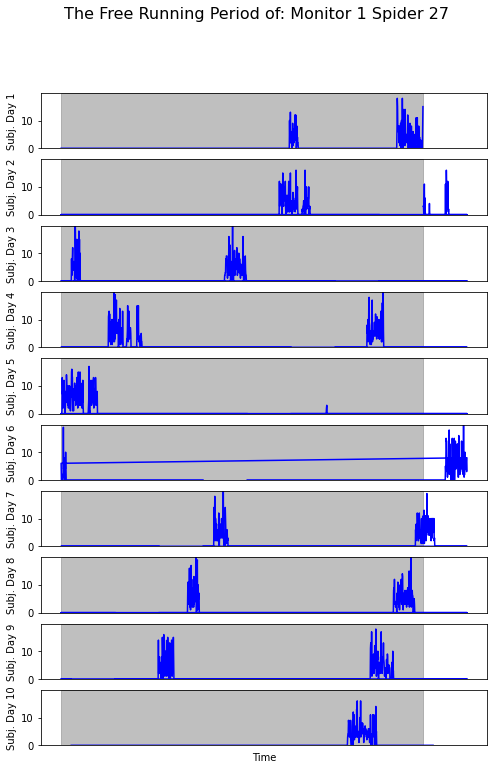

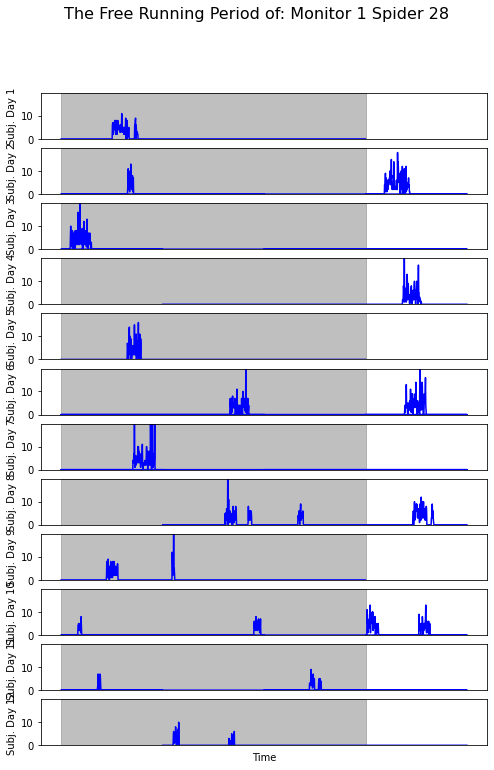

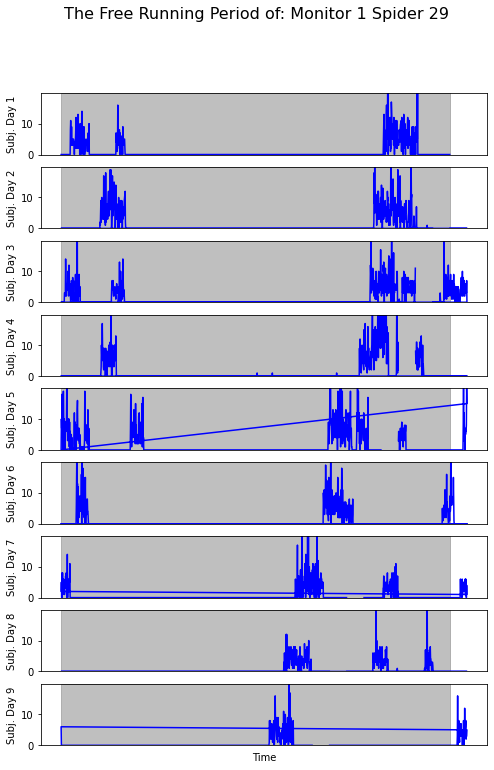

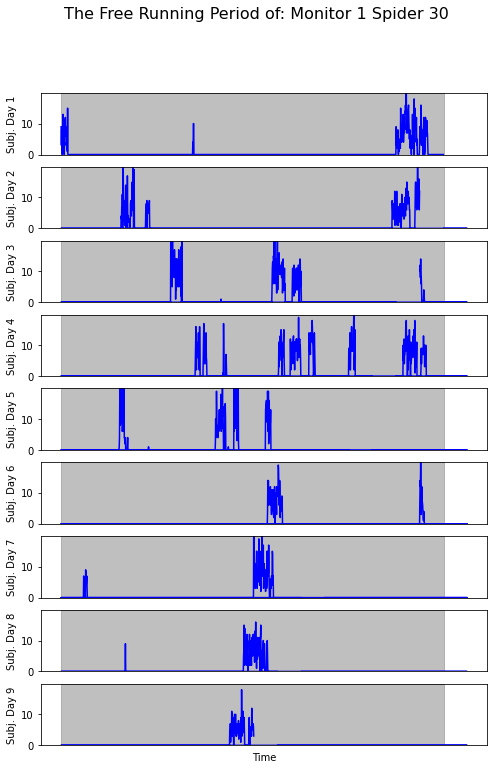

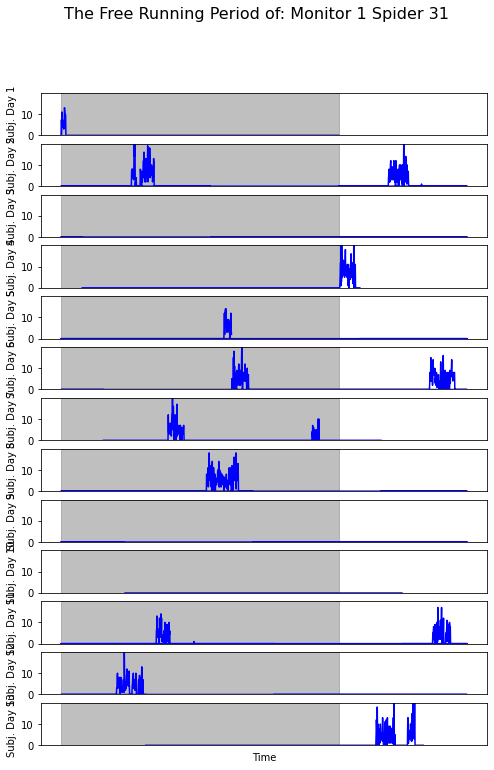

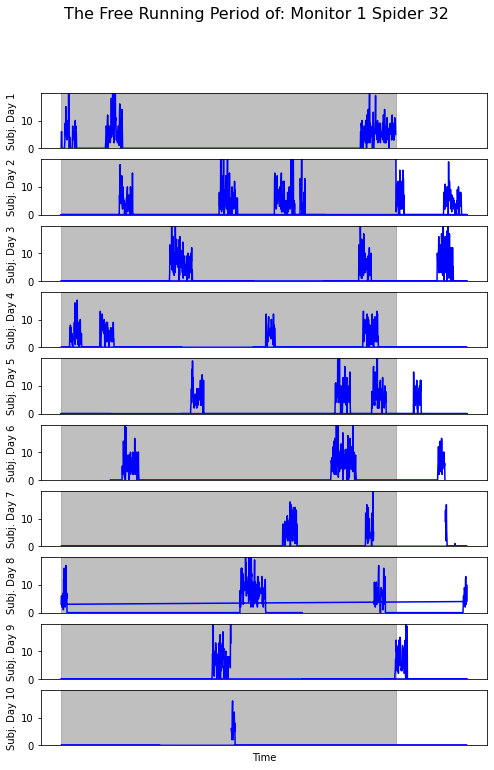

In [27]:
spider_raster(df,per)